# Import Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Load the preprocessed data


In [3]:
data_dir = Path("../../data/processed")  
files = {
    "DF": data_dir / "players_data_DF_normalized.parquet",
    "FW": data_dir / "players_data_FW_normalized.parquet",
    "GK": data_dir / "players_data_GK_normalized.parquet",
    "MF": data_dir / "players_data_MF_normalized.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_fw = load_clean(files["FW"])
df_df = load_clean(files["DF"])
df_gk = load_clean(files["GK"])
df_mf = load_clean(files["MF"])



# Cluster Forwards 

In [4]:
print("FW shape:", df_fw.shape)
df_fw.head()
df_fw.info()
df_fw.describe()
df_fw.select_dtypes(include="object").columns


# drop_cols = ["__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
categorical_cols = ['Rk','Player', 'Nation', 'Pos','Squad', 'Comp', 'Age','Born','MP','Starts','Min','90s',
                    'numeric_wage', 'foot', 'W', 'D', 'L']
fw_features = df_fw.drop(columns=categorical_cols, errors="ignore")



# Print the shape and preview of the numeric dataset
print("Numeric dataset shape:", fw_features.shape)
fw_features.head()

fw_scaled = fw_features  # Data is already normalized


# Apply PCA to reduce dimensions to 2D for plotting and visualization
pca = PCA(n_components=5, random_state=42)
fw_pca5 = pca.fit_transform(fw_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, algorithm='elkan')
fw_clusters = kmeans.fit_predict(fw_pca5)
# Add cluster labels to the original dataframe for easy reference
df_fw["cluster"] = fw_clusters



FW shape: (464, 126)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Columns: 126 entries, Rk to exposure_score
dtypes: float64(116), int64(4), object(6)
memory usage: 456.9+ KB
Numeric dataset shape: (464, 112)


### Plot and List

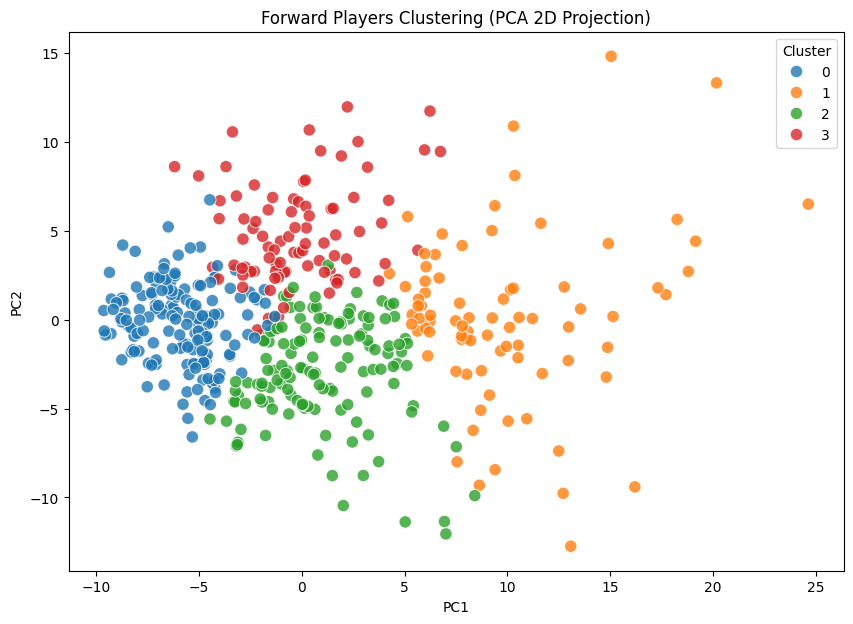

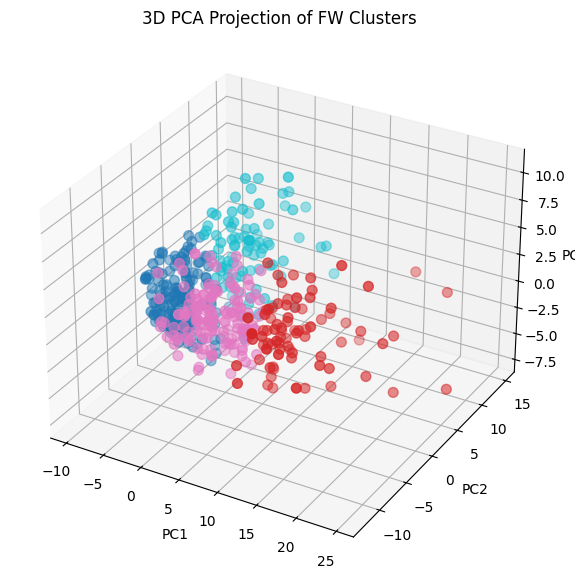

Eigenvalues (variance explained by each PC): [36.74796924 16.42020553  9.24214873  5.49579541  3.69633045]
Explained variance ratio: [0.33457829 0.14950062 0.08414675 0.05003743 0.03365388]
Cumulative variance explained: [0.33457829 0.48407891 0.56822567 0.61826309 0.65191698]


In [6]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=fw_pca5[:,0], 
    y=fw_pca5[:,1], 
    hue=df_fw["cluster"],       
    palette="tab10", 
    s=80,
    alpha=0.8
)



plt.title("Forward Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()



# Use the first 3 principal components from the 5D PCA for 3D visualization
fw_pca_3d = fw_pca5[:, :3]   # PC1, PC2, PC3

# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    fw_pca_3d[:,0], fw_pca_3d[:,1], fw_pca_3d[:,2],
    c=df_fw["cluster"], cmap="tab10", s=50
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of FW Clusters")
plt.show()

# Print eigenvalues / explained variance from the same PCA
print("Eigenvalues (variance explained by each PC):", pca.explained_variance_[:5])
print("Explained variance ratio:", pca.explained_variance_ratio_[:5])
print("Cumulative variance explained:", np.cumsum(pca.explained_variance_ratio_[:5]))


In [7]:
df_fw.head()

cluster_0_players = df_fw[df_fw["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
print(f"Players in cluster 0: {len(cluster_0_players)}")
cluster_0_players




Players in cluster 0: 81


,Player,Squad,Pos,cluster
0,Himad Abdelli,Angers,"MF,FW",1
11,Maghnes Akliouche,Monaco,"FW,MF",1
19,Julián Álvarez,Atlético Madrid,FW,1
20,Mohamed Amoura,Wolfsburg,FW,1
35,Alex Baena,Villarreal,"MF,FW",1
...,...,...,...,...
442,Nico Williams,Athletic Club,FW,1
447,Florian Wirtz,Leverkusen,"MF,FW",1
453,Lamine Yamal,Barcelona,FW,1
456,Kenan Yıldız,Juventus,"FW,MF",1


### Evaluate

In [9]:

sil_score = silhouette_score(fw_pca5, df_fw["cluster"])
print("Silhouette Score:", sil_score)


dbi = davies_bouldin_score(fw_pca5, df_fw["cluster"])
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(fw_pca5, df_fw["cluster"])
print("Calinski-Harabasz Score:", ch_score)

# After fitting PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=fw_features.columns
)

# Sort features by importance for PC1 and PC2
loadings_PC1 = loadings["PC1"].abs().sort_values(ascending=False)
loadings_PC2 = loadings["PC2"].abs().sort_values(ascending=False)
loadings_PC3 = loadings["PC3"].abs().sort_values(ascending=False)
loadings_PC4 = loadings["PC4"].abs().sort_values(ascending=False)
loadings_PC5 = loadings["PC5"].abs().sort_values(ascending=False)

print("Top PC1 drivers:\n", loadings_PC1.head(15))
print("\nTop PC2 drivers:\n", loadings_PC2.head(15))
print("\nTop PC3 drivers:\n", loadings_PC3.head(15))
print("\nTop PC4 drivers:\n", loadings_PC4.head(15))
print("\nTop PC5 drivers:\n", loadings_PC5.head(15))

low_variance = fw_features.var().sort_values().head(50)
print(low_variance)

Silhouette Score: 0.24172772134091033
Davies-Bouldin Index: 1.3151741128151697
Calinski-Harabasz Score: 173.47999990487085
Top PC1 drivers:
 Carries                     0.157019
Rec                         0.156349
Touches                     0.156173
Live_stats_possession       0.156112
Att 3rd_stats_possession    0.154854
SCA                         0.153778
PassLive                    0.151238
Live                        0.149117
Att                         0.148291
TotDist_stats_possession    0.146700
KP                          0.144595
Cmp                         0.142717
PrgDist_stats_possession    0.141269
PrgP                        0.141127
PPA                         0.140644
Name: PC1, dtype: float64

Top PC2 drivers:
 xG+xAG                      0.200939
npxG                        0.198415
SoT/90                      0.196702
xG                          0.195912
G+A-PK                      0.183146
Sh/90                       0.181389
SoT                         0.179585


# Clustering Forwards (Feature Selection with PC1 to PC5)

## Feature Selection

,Selected Features
0,Carries
1,xG
2,SoT/90
3,xA
4,SCA90
5,npxG+xAG
6,Def Pen
7,KP
8,Rec
9,SCA


K=4: Silhouette Score = 0.2414
Davies-Bouldin Index: 1.402440372158402
Calinski-Harabasz Score: 161.01332464149897


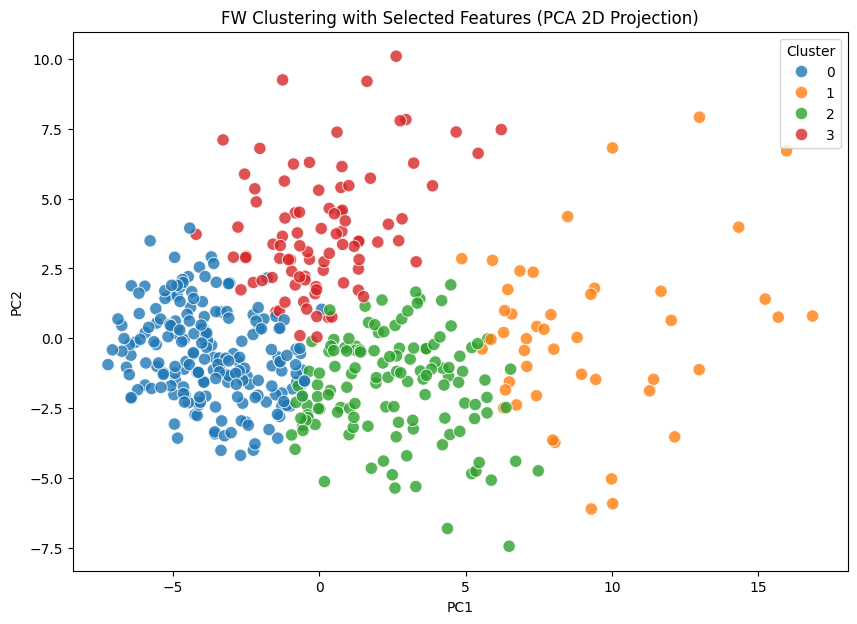

Players in cluster 0: 201


,Player,Squad,Pos,cluster
3,Tammy Abraham,Milan,FW,0
4,Akor Adams,Montpellier,FW,0
6,Junior Adamu,Freiburg,FW,0
8,Simon Adingra,Brighton,"FW,MF",0
9,Oladapo Afolayan,St. Pauli,"FW,MF",0
...,...,...,...,...
455,Bertuğ Yıldırım,Getafe,FW,0
458,Alessandro Zanoli,Genoa,"FW,DF",0
461,Joshua Zirkzee,Manchester Utd,"FW,MF",0
462,Budu Zivzivadze,Heidenheim,FW,0


Players in cluster 1: 46


,Player,Squad,Pos,cluster
0,Himad Abdelli,Angers,"MF,FW",1
11,Maghnes Akliouche,Monaco,"FW,MF",1
19,Julián Álvarez,Atlético Madrid,FW,1
35,Alex Baena,Villarreal,"MF,FW",1
39,Bradley Barcola,Paris S-G,FW,1
60,Jarrod Bowen,West Ham,"FW,MF",1
80,Rayan Cherki,Lyon,"FW,MF",1
90,Matheus Cunha,Wolves,"MF,FW",1
93,Mikkel Damsgaard,Brentford,"MF,FW",1
99,Kevin De Bruyne,Manchester City,"MF,FW",1


Players in cluster 2: 128


,Player,Squad,Pos,cluster
16,Domingos André Ribeiro Almeida,Valencia,"MF,FW",2
20,Mohamed Amoura,Wolfsburg,FW,2
23,Antony,Betis,FW,2
27,Hákon Arnar Haraldsson,Lille,"MF,FW",2
29,Iago Aspas,Celta Vigo,"FW,MF",2
...,...,...,...,...
442,Nico Williams,Athletic Club,FW,2
445,Patrick Wimmer,Wolfsburg,"MF,FW",2
457,Mattia Zaccagni,Lazio,FW,2
459,Bryan Zaragoza,Osasuna,"FW,MF",2


Players in cluster 3: 89


,Player,Squad,Pos,cluster
1,Matthis Abline,Nantes,FW,3
2,Zakaria Aboukhlal,Toulouse,"MF,FW",3
5,Che Adams,Torino,FW,3
7,Karim Adeyemi,Dortmund,"FW,MF",3
10,Ludovic Ajorque,Brest,FW,3
...,...,...,...,...
440,Danny Welbeck,Brighton,FW,3
446,Jonas Wind,Wolfsburg,"FW,MF",3
448,Yoane Wissa,Brentford,FW,3
450,Nick Woltemade,Stuttgart,"FW,MF",3


In [14]:
# Drop features with low variance and select top features from PC1 to PC5
selected_features = list(loadings_PC1.head(20).index) + list(loadings_PC2.head(10).index) + list(loadings_PC3.head(10).index)
selected_features = list(set(selected_features))  # Remove duplicates
selected_features_df = pd.DataFrame(selected_features, columns=["Selected Features"])
display(selected_features_df)



fw_scaled_sel = df_fw[selected_features].copy()
# Make Nan values 0
# fw_sel = fw_sel.fillna(0)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# fw_scaled_sel = scaler.fit_transform(fw_sel)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(fw_scaled_sel)
sil = silhouette_score(fw_scaled_sel, clusters)
print(f"K=4: Silhouette Score = {sil:.4f}")

# Evaluate
dbi = davies_bouldin_score(fw_scaled_sel, clusters)
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(fw_scaled_sel, clusters)
print("Calinski-Harabasz Score:", ch_score)

# Add cluster labels to the original dataframe for easy reference
df_fw["cluster"] = clusters

# Plotting with selected features
pca_sel3 = PCA(n_components=3, random_state=42)
fw_pca_sel = pca_sel3.fit_transform(fw_scaled_sel)
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=fw_pca_sel[:,0], 
    y=fw_pca_sel[:,1], 
    hue=clusters,       
    palette="tab10", 
    s=80,
    alpha=0.8
)
plt.title("FW Clustering with Selected Features (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# List players from cluster 1

cluster_0_players = df_fw[df_fw["cluster"] == 0][["Player", "Squad", "Pos", "cluster"]]
cluster_1_players = df_fw[df_fw["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
cluster_2_players = df_fw[df_fw["cluster"] == 2][["Player", "Squad", "Pos", "cluster"]]
cluster_3_players = df_fw[df_fw["cluster"] == 3][["Player", "Squad", "Pos", "cluster"]]

print(f"Players in cluster 0: {len(cluster_0_players)}")
display(cluster_0_players)
print(f"Players in cluster 1: {len(cluster_1_players)}")
display(cluster_1_players)
print(f"Players in cluster 2: {len(cluster_2_players)}")
display(cluster_2_players)
print(f"Players in cluster 3: {len(cluster_3_players)}")
display(cluster_3_players)







In [15]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

feature_cols = selected_features
X = fw_scaled_sel.values
labels = clusters

per_cluster_nn = {}
per_cluster_idx = {}

for c in np.unique(labels):
    indx = np.where(labels == c)[0]
    Xc = X[indx, :]
    # n_neighbors+1 to allow excluding self at query time
    nn = NearestNeighbors(n_neighbors=min(11, len(indx)), metric="euclidean", algorithm="auto")
    nn.fit(Xc)
    per_cluster_nn[c] = nn
    per_cluster_idx[c] = indx

def nearest_players_within_cluster(df, player_name=None, row_idx=None, k=5, id_col="Player"):
    if player_name is None and row_idx is None:
        raise ValueError("Provide either player_name or row_idx.")
    if row_idx is None:
        match = df.index[df[id_col] == player_name].tolist()
        if not match:
            raise ValueError(f"Player '{player_name}' not found in column '{id_col}'.")
        row_idx = match[0]

    c = labels[row_idx]
    nn = per_cluster_nn[c]
    idx = per_cluster_idx[c]

    xq = X[row_idx].reshape(1, -1)
    n_q = min(k+1, len(idx))
    dists, inds = nn.kneighbors(xq, n_neighbors=n_q)
    dists, inds = dists[0], inds[0]

    global_inds = idx[inds]
    mask = global_inds != row_idx
    global_inds = global_inds[mask]
    dists = dists[mask]
    global_inds = global_inds[:k]
    dists = dists[:k]

    cols_to_show = [c for c in [id_col, "Rk", "Pos", "Squad", "cluster"] if c in df.columns]
    out = df.iloc[global_inds][cols_to_show].copy()
    out["distance"] = dists
    return out.reset_index(drop=True)

# Example usage:
display(nearest_players_within_cluster(df_fw, player_name="Lamine Yamal", k=10))

,Player,Rk,Pos,Squad,cluster,distance
0,Michael Olise,1961,"FW,MF",Bayern Munich,1,5.266391
1,Cole Palmer,2034,"MF,FW",Chelsea,1,6.645242
2,Florian Wirtz,2780,"MF,FW",Leverkusen,1,7.100726
3,Raphinha,2178,"FW,MF",Barcelona,1,7.627466
4,Mason Greenwood,1061,"FW,MF",Marseille,1,7.913600
5,Rayan Cherki,542,"FW,MF",Lyon,1,8.531213
6,Mohamed Salah,2305,FW,Liverpool,1,8.802460
7,Alex Baena,201,"MF,FW",Villarreal,1,9.109115
8,Maghnes Akliouche,67,"FW,MF",Monaco,1,9.320174
9,Alex Iwobi,1231,"FW,MF",Fulham,1,9.344953
